In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import re
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("/content/XSS_dataset.csv")  # Replace with the correct path if needed
df = df[['Sentence', 'Label']]
df['Sentence'] = df['Sentence'].astype(str).str.strip()

In [3]:
plain_benign = [
    "mohamed", "hello", "apple", "blueSky", "python3", "user123", "test",
    "gdyugs", "w663t", "sara", "sunshine99", "chatgpt", "normalText", "xssfree",
    "flower", "zebra22", "cloud", "secure", "123456", "abc123"
]

In [5]:
import random
augmented_benign = random.choices(plain_benign, k=300)
augmented_df = pd.DataFrame({"Sentence": augmented_benign, "Label": [0] * len(augmented_benign)})


In [6]:
df_augmented = pd.concat([df, augmented_df], ignore_index=True)
df_augmented = df_augmented.sample(frac=1, random_state=42).reset_index(drop=True)

In [7]:
df_augmented['Sentence'] = df_augmented['Sentence'].str.lower().str.strip()


In [8]:
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(df_augmented['Sentence'])

In [9]:
X = tokenizer.texts_to_sequences(df_augmented['Sentence'])


In [10]:
seq_lengths = [len(seq) for seq in X]
max_len = int(np.percentile(seq_lengths, 95))  # based on 95th percentile
X_padded = pad_sequences(X, maxlen=max_len, padding='post', truncating='post')


In [11]:
y = df_augmented['Label'].values


In [12]:
vocab_size = len(tokenizer.word_index) + 1


In [13]:
# === 3. BUILD BiLSTM MODEL ===
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=64, input_length=max_len),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [14]:
# === 4. TRAINING ===
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_padded, y, test_size=0.2, random_state=42)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=64,
    verbose=1
)


Epoch 1/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - accuracy: 0.8702 - loss: 0.2928 - val_accuracy: 0.9925 - val_loss: 0.0284
Epoch 2/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.9896 - loss: 0.0309 - val_accuracy: 0.9900 - val_loss: 0.0275
Epoch 3/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.9941 - loss: 0.0180 - val_accuracy: 0.9961 - val_loss: 0.0112
Epoch 4/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.9955 - loss: 0.0171 - val_accuracy: 0.9803 - val_loss: 0.0462
Epoch 5/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.9896 - loss: 0.0378 - val_accuracy: 0.9961 - val_loss: 0.0172
Epoch 6/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.9932 - loss: 0.0214 - val_accuracy: 0.9964 - val_loss: 0.0135
Epoch 7/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9980 - loss: 0.0102 - val_accuracy: 0.9971 - val_loss: 0.0096
Epoch 8/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.9980 - loss: 0.0099 - val_ac

In [15]:
# === 5. PREDICT CUSTOM INPUT ===
def predict_input(text):
    text = text.lower().strip()
    seq = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(seq, maxlen=max_len, padding='post', truncating='post')
    pred = model.predict(padded)[0][0]
    label = "Malicious" if pred >= 0.5 else "Benign"
    print(f"Input: {text} | Prediction: {label} ({pred:.4f})")


In [34]:

predict_input('<iframe srcdoc="<script>${\'ale\'+\'rt(1)\'}</script>">')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Input: <iframe srcdoc="<script>${'ale'+'rt(1)'}</script>"> | Prediction: Malicious (0.9999)


In [37]:

predict_input("w663t")
predict_input("<script>alert(1)</script>")
predict_input("<img src=x onerror=alert(1)>")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Input: w663t | Prediction: Benign (0.0032)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Input: <script>alert(1)</script> | Prediction: Malicious (0.9913)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Input: <img src=x onerror=alert(1)> | Prediction: Malicious (1.0000)


In [36]:
import pickle

with open("xss_tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)


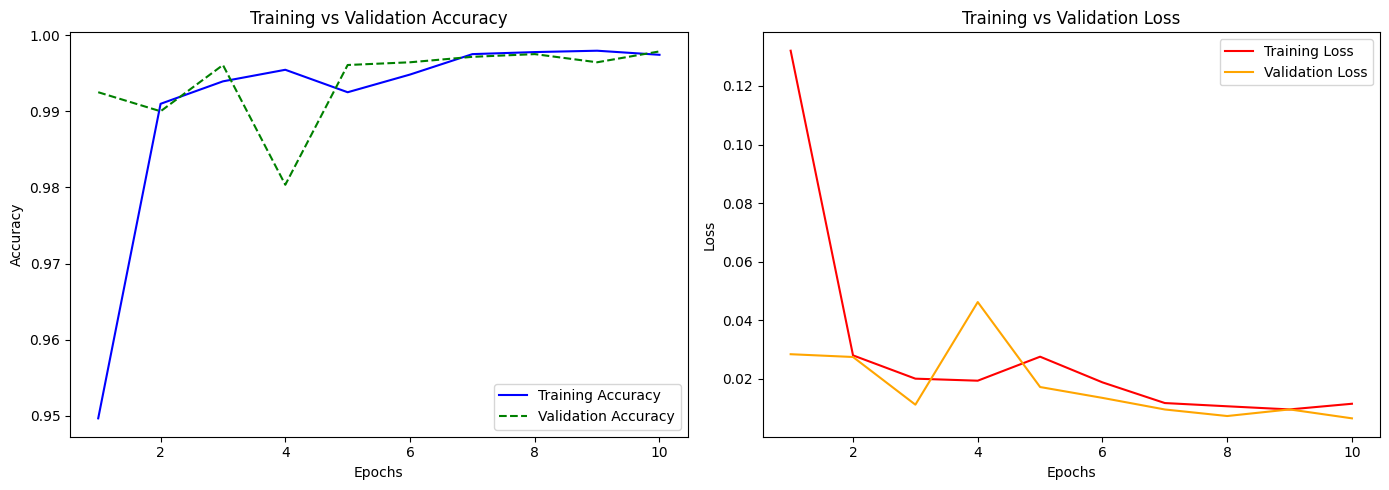

In [38]:
model.save("xss_bilstm_model.h5")


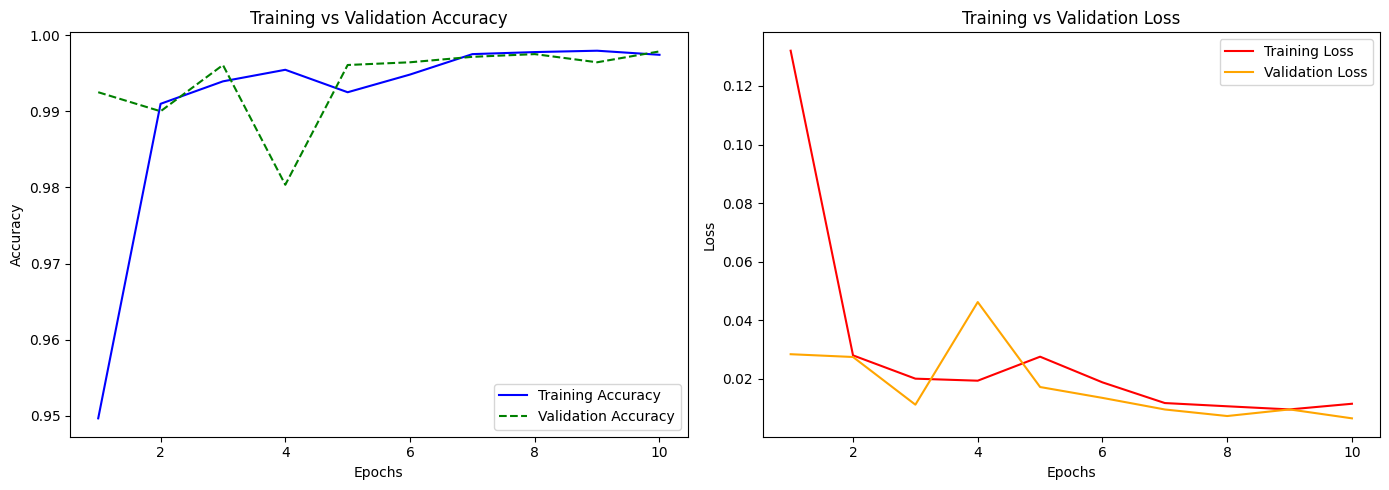

In [39]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'g--', label='Validation Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'r-', label='Training Loss')
    plt.plot(epochs, val_loss, 'orange', label='Validation Loss')
    plt.title('Training vs Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Use this after training
plot_training_history(history)


88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step


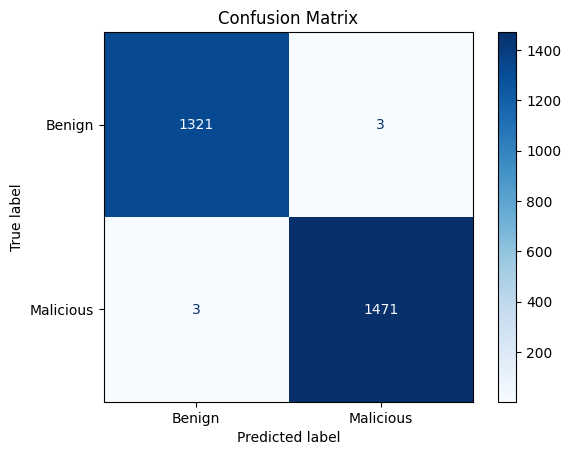

In [40]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict on validation set
y_pred = (model.predict(X_val) >= 0.5).astype(int)

# Confusion matrix
cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Benign", "Malicious"])

disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


In [41]:
from sklearn.metrics import classification_report

print(classification_report(y_val, y_pred, target_names=["Benign", "Malicious"]))


              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00      1324
   Malicious       1.00      1.00      1.00      1474

    accuracy                           1.00      2798
   macro avg       1.00      1.00      1.00      2798
weighted avg       1.00      1.00      1.00      2798



88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step


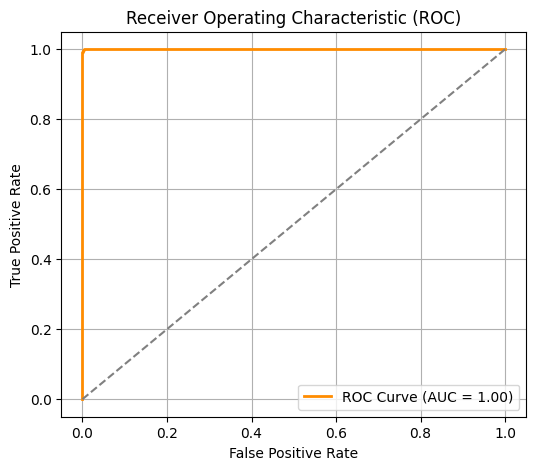

In [42]:
from sklearn.metrics import roc_curve, auc

y_probs = model.predict(X_val).ravel()
fpr, tpr, thresholds = roc_curve(y_val, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [43]:
new_texts = [
    '<script>alert(1)</script>',    # Malicious
    'Hello, how are you?',          # Benign
    '<img src=x onerror=alert(2)>', # Malicious
    'Just some harmless text'       # Benign
]

# If you have labels for this new data:
y_new = [1, 0, 1, 0]


In [44]:
from keras.models import load_model
import pickle

model = load_model("xss_bilstm_model.h5")
with open("xss_tokenizer.pkl", "rb") as f:
    tokenizer = pickle.load(f)


In [45]:
from keras.utils import pad_sequences

def preprocess_texts(texts, tokenizer, max_len):
    sequences = tokenizer.texts_to_sequences(texts)
    padded = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')
    return padded

YOUR_MAX_LEN = 100  # Replace with your actual max length used during training
X_new = preprocess_texts(new_texts, tokenizer, YOUR_MAX_LEN)


In [46]:
pred_probs = model.predict(X_new).ravel()
pred_labels = (pred_probs >= 0.5).astype(int)  # Threshold 0.5 for binary classification

for text, prob, label in zip(new_texts, pred_probs, pred_labels):
    print(f"Text: {text}")
    print(f"Predicted Probability of Malicious: {prob:.4f}")
    print(f"Predicted Label: {'Malicious' if label else 'Benign'}")
    print("-" * 40)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
Text: <script>alert(1)</script>
Predicted Probability of Malicious: 0.9913
Predicted Label: Malicious
----------------------------------------
Text: Hello, how are you?
Predicted Probability of Malicious: 0.0029
Predicted Label: Benign
----------------------------------------
Text: <img src=x onerror=alert(2)>
Predicted Probability of Malicious: 1.0000
Predicted Label: Malicious
----------------------------------------
Text: Just some harmless text
Predicted Probability of Malicious: 0.2980
Predicted Label: Benign
----------------------------------------


In [47]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_new, pred_labels, target_names=["Benign", "Malicious"]))

cm = confusion_matrix(y_new, pred_labels)
print("Confusion Matrix:\n", cm)


              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00         2
   Malicious       1.00      1.00      1.00         2

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4

Confusion Matrix:
 [[2 0]
 [0 2]]
